# Project 2

| Name         | PID          | 
|--------------|--------------|
| Peter Murphy | `petermurphy`|
|Joseph McAlister | `josephrm`|
    
We have neither given nor received unauthorized assistance on this assignment. See the course sylabus for details on the Honor Code policy. In particular, sharing lines of solution code is prohibited.

### Team - "Team Name"

In [1]:
# imports used 
import pandas as pd
from bs4 import BeautifulSoup as soup
from bs4 import Tag
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import requests
import csv 

# Q1 : Qualitative

## Q1.1: Introduction / Initial Problem Statement
Our goal is to find relationships in suicide rates according to country, age demographic, generation, gdp, and year in roughly the past three decades.

Specifically, some questions we think might be interesting to investigate in depth include:
1. What country has the most suicides, or the highest average rate of suicide from year to year?
2. Is there a relationship between generation or age demographic and propensity for suicide?
3. Is there relationship between a country's gdp and rate of suicide?
4. Do the events of a given year have an impact on global or regionally focused suicides?  If so, which years and what kinds of events?
  - Create our own criteria based on findings, if we can, that contribute to the negation of high suicide rates (e.g. high gdp? positive words in the text analysis as well). As the motivation of the Q.

## Q1.2 Data Collection
Our [primary data set](https://www.kaggle.com/russellyates88/suicide-rates-overview-1985-to-2016) taken from Kaggle has sufficient information to examine the first 3 hypotheses, but in order to qualify/quantify information about the events from each year which may provide insights into the cause of change in this data from year to year, country to country, etc., we need to collect more data in the hopes of modelling a sentiment value that we can ascribe to each of the years contained within our first data set.

To gather information about each year from 1985 - 2016, we webscrape the Wikipedia pages for each year, saving each of the notable events (see the attached image) into a dataframe which we can further mine for positive/negative sentiment which may give insight into why some years show a global/regional/isolated increase or decrease in suicide rates from year to year or country to country.

![](img1.png)

We observe that each of the relevant bullet points under the `Events` heading on the webpage is stored in a `<ul>` element that directly follows the `<h3>` tag containing a `<span>` describing the month of the year.  With this in mind, our approach is to find the `<span>` tags corresponding to each month, navigate to the next `<ul>` immediately proceeding that `<span>` and gather the text fields from each constituent `<li>` tag within. 

In [2]:
DATA_ALREADY_COLLECTED = True # a flag which can be used to skip the data collection process

In [3]:
if not DATA_ALREADY_COLLECTED:
    years = range(1985, 2017) # the years that correspond to our master data set
    months = ['January', 'February', 'March', 'April', 'May', 'June', 
              'July', 'August', 'September', 'October', 'November', 'December']
    base_url = "https://en.wikipedia.org/wiki"

    events = pd.DataFrame()   # stores each event  

    for year in years:        # iterate over each year
        print('.', end='')    # hacky loading bar to indicate progress
        url = f"{base_url}/{year}"

        response = requests.get(url)
        if response.status_code != 200:
            print(f"GET failed with response code: {response.status_code}")
            raise

        year_soup = soup(response.text, 'html5lib')

        for month in months:                             # iterate over each month
            span = year_soup.find('span', {'id': month}) # find the corresponding span
            for elem in span.parent.findNext('ul'):      # iterate over each element in the ul tag that follows
                if isinstance(elem, Tag):                # ensure the element is a Tag (not a NavigableString) 
                    # append the contents of the element to the dataframe
                    events = events.append({'year': int(year), 
                                            'month': month, 
                                            'text': elem.get_text().encode('ascii','ignore').decode()}, 
                                           ignore_index=True)
    events = events[['year', 'month', 'text']]            # reorder columns for clarity
    events['year'] = events['year'].astype('int')         # remove annoying decimal
    # save the data and set the flag so this can be skipped in the future
    with open('data/events.csv', 'w') as f:
        f.write(events.to_csv())
        DATA_ALREADY_COLLECTED = True
else: 
    events = pd.read_csv('data/events.csv')
    events = events.drop('Unnamed: 0', axis=1) # drop the excess index column if preloading

events

,year,month,text
0,1985,January,January 1\r\nThe Internet's Domain Name System...
1,1985,January,January 7 Japan Aerospace Exploration Agency ...
2,1985,January,"January 10 Sinclair C5, the world's first mas..."
3,1985,January,January 13 A passenger train plunges into a r...
4,1985,January,January 15 Tancredo Neves is elected presiden...
...,...,...,...
2948,2016,December,"December 19 Andrei Karlov, the Russian ambass..."
2949,2016,December,December 22 A study finds the VSV-EBOV vaccin...
2950,2016,December,December 23 The United Nations Security Counc...
2951,2016,December,December 25 2016 Russian Defence Ministry Tup...


## Q1.3 Data Processing
Next, we want to process and group our data in order to make it easier to analyze our posed questions.

### Q1.3.1 Processing the `Events` Data Set

Beginning with the `events` data set above:
- We clean the data and filter out stop words,
- Tally the number of negative and positive words in each entry using the bag of words approach
  - keep an additional tally of mentions of topical keywords like 'suicide', 'suicidal', etc.
- Add additional measures of sentiment (negative, positive, topical) according to year which we can further join with our primary dataset as needed

In [4]:
# load / define words of negative sentiment
negatives = list(set(open('data/negative.txt').read().split()))
positives = list(set(open('data/positive.txt').read().split()))
stopwords = list(set(open('data/stopwords.txt').read().split()))
keywords = ['suicide', 'suicidal', 'depression'] # define custom topical keywords

def min_max_norm(series):
    return (series - series.min()) / (series.max() - series.min())

# create bag of words/sentiment for each row, 
events_cleaned = events.copy()

# remove unnecessary characters from the text column
events_cleaned['text'] = events_cleaned['text'].apply(lambda t: 
    t.replace(',',' ').replace('.', ' ').replace('\n', ' '))

# store non-stopwords
events_cleaned['bag'] = events_cleaned['text'].apply(lambda w: 
    [w for w in w.lower().split() if w not in stopwords])

# store negative words
events_cleaned['neg_words'] = events_cleaned['bag'].apply(lambda bag: 
    [w for w in bag if w in negatives])

# store positive words
events_cleaned['pos_words'] = events_cleaned['bag'].apply(lambda bag: 
    [w for w in bag if w in positives])

# store topical keywords
events_cleaned['keywords'] = events_cleaned['bag'].apply(lambda bag: 
    [w for w in bag if w in keywords])

# tally number of negatives
events_cleaned['n_neg_words'] = events_cleaned['neg_words'].apply(lambda t: len(t))

# tally number of positives
events_cleaned['n_pos_words'] = events_cleaned['pos_words'].apply(lambda t: len(t))

# tally number of keywords 
events_cleaned['n_keywords'] = events_cleaned['keywords'].apply(lambda t: len(t))

# tally number of total meaningful words
events_cleaned['n_total_words'] = events_cleaned['bag'].apply(lambda t: len(t))

# extract a negative sentiment value 
events_cleaned['neg_sentiment'] = events_cleaned.apply(lambda row: row['n_neg_words']/row['n_total_words'], axis=1)
# normalize neg_sentiment between 0, 1
events_cleaned['neg_sentiment'] = (events_cleaned['neg_sentiment'] - events_cleaned['neg_sentiment'].min()) / (events_cleaned['neg_sentiment'].max() - events_cleaned['neg_sentiment'].min())

# extract a positive sentiment value 
events_cleaned['pos_sentiment'] = events_cleaned.apply(lambda row: row['n_pos_words']/row['n_total_words'], axis=1)
# normalize pos_sentiment between 0, 1
events_cleaned['pos_sentiment'] = (events_cleaned['pos_sentiment'] - events_cleaned['pos_sentiment'].min()) / (events_cleaned['pos_sentiment'].max() - events_cleaned['pos_sentiment'].min())

# extract a topical keyword sentiment value 
events_cleaned['topical_sentiment'] = events_cleaned.apply(lambda row: row['n_keywords']/row['n_total_words'], axis=1)
events_cleaned['topical_sentiment'] = (events_cleaned['topical_sentiment'] - events_cleaned['topical_sentiment'].min()) / (events_cleaned['topical_sentiment'].max() - events_cleaned['topical_sentiment'].min())

events_cleaned.sort_values('pos_sentiment', ascending=False).head()

,year,month,text,bag,neg_words,pos_words,keywords,n_neg_words,n_pos_words,n_keywords,n_total_words,neg_sentiment,pos_sentiment,topical_sentiment
597,1989,November,November 6 The Asia-Pacific Economic Cooperat...,"[november, 6, asia-pacific, economic, cooperat...",[],"[cooperation, established]",[],0,2,0,7,0.000000,1.000000,0.0
1353,1994,July,July 4 Rwandan Patriotic Front troops capture...,"[july, 4, rwandan, patriotic, troops, capture,...",[war],"[patriotic, breakthrough, civil]",[],1,3,0,12,0.291667,0.875000,0.0
1296,1994,January,January 1\r The North American Free Trade Agre...,"[january, 1, north, american, free, trade, agr...",[war],"[free, agreement, established, liberation]",[],1,4,0,17,0.205882,0.823529,0.0
305,1987,October,October 3 The CanadaUnited States Free Trade ...,"[october, 3, canadaunited, states, free, trade...",[],"[free, agreement, agreement]",[],0,3,0,13,0.000000,0.807692,0.0
523,1989,June,June 22 Ireland's first universities establis...,"[june, 22, ireland's, universities, establishe...",[],"[established, independence, open]",[],0,3,0,13,0.000000,0.807692,0.0


By sorting our `cleaned_events` data according to the various sentiments, we can see that our naive heuristic of $$\frac{\texttt{# positive, #negaitve, or #topical}}{\texttt{#total}}$$ appropriately measuress the desired characteristics. 

We can examine the top few entries for each to verify.

#### Q1.3.1.1 Events Tagged With Positive Sentiment
Here we can see that each of the most positively rated events _do_ correspond to good things such as:
- establishment of cooperative pacts, agreements, or institutions (APEC, NAFTA, Irish universities)
- breakthroughs in violent conflicts, peace deals.

However, we can also see some areas where our heuristic missassigns some positive scores for conveniently worded, or outright bland events such as:
- "The Islamic Salvation Army the armed wing of the Islamic Salvation Front agrees in principle to disband in Algeria"
- "The Marshall Islands became an associated state under the Compact of Free Association" 

both of which received positive scores due to language which may be have otherwise been ignored or even penalized given the context.

In [5]:
top5 = events_cleaned.sort_values('pos_sentiment', ascending=False).head(10).drop(
    ['bag', 'month','neg_words','keywords', 'n_pos_words', 'n_keywords', 'n_neg_words', 
     'n_total_words', 'topical_sentiment', 'neg_sentiment'], axis=1)
top5

,year,text,pos_words,pos_sentiment
597,1989,November 6 The Asia-Pacific Economic Cooperat...,"[cooperation, established]",1.000000
1353,1994,July 4 Rwandan Patriotic Front troops capture...,"[patriotic, breakthrough, civil]",0.875000
1296,1994,January 1\r The North American Free Trade Agre...,"[free, agreement, established, liberation]",0.823529
305,1987,October 3 The CanadaUnited States Free Trade ...,"[free, agreement, agreement]",0.807692
523,1989,June 22 Ireland's first universities establis...,"[established, independence, open]",0.807692
1578,1996,September 2 A permanent peace agreement is si...,"[peace, agreement, liberation]",0.807692
2424,2008,January 24 A peace deal is signed in Goma De...,"[peace, deal, democratic]",0.807692
1861,1999,June 5 The Islamic Salvation Army the armed ...,"[salvation, salvation, principle]",0.807692
211,1986,October 21 The Marshall Islands became an ass...,"[compact, free]",0.777778
115,1985,December 8 The South Asian Association for Re...,"[cooperation, established]",0.777778


#### Q1.3.1.2 Events Tagged With Negative Sentiment
Similarly for negative and topically scored entries, we see generally appropriate events such as:
- acts of war, war crimes, and terror
- disasters, protests, massacres, outbreaks
- suicides

In [6]:
top5 = events_cleaned.sort_values('neg_sentiment', ascending=False).head(10).drop(
    ['bag', 'month','pos_words','keywords', 'n_pos_words','n_neg_words','n_keywords', 
     'n_total_words', 'topical_sentiment', 'pos_sentiment'], axis=1)
top5

,year,text,neg_words,neg_sentiment
528,1989,July 6 The Tel AvivJerusalem bus 405 suicide ...,"[suicide, attack, suicide, attack]",1.000000
1039,1992,March 3 Turkey's worst coal mine disaster lea...,"[worst, disaster, dead]",0.954545
2894,2015,December 15 The Islamic Military Counter Terr...,"[terrorism, fight, terrorism]",0.875000
1259,1993,September 27 War in Abkhazia: Fall of Sukhumi...,"[war, accuses, passive]",0.875000
260,1987,May 11 Klaus Barbie goes on trial in Lyon for...,"[trial, war, war]",0.875000
1072,1992,May 17 Protests begin in Bangkok Thailand a...,"[protests, bloody, crackdown]",0.875000
294,1987,August 17 Rudolf Hess is found dead in his ce...,"[dead, prison, suicide, prisoner, complex]",0.795455
245,1987,February 25 Beginning of the Phosphorite War ...,"[war, protest]",0.777778
1831,1999,March 15 In Brussels Belgium the Santer Com...,"[allegations, corruption]",0.777778
698,1990,April 13 Cold War: The Soviet Union apologize...,"[cold, massacre]",0.777778


#### Q1.3.1.3 Events Tagged With Topical Sentiment
Something which immediately stands out to us is the significant overlap in topical and negative keywords, namely 'suicide'.  Only one of the top ten events pertaining to our topical keywords actually covers the context that we are concerned with: "March 24 26 In San Diego 39 Heaven's Gate cultists commit mass suicide at their compound." 

This indicates that our topical classification lacks sufficient context to delineate between suicide and suicide bombings. For the sake of our research questions, want to ensure to distinguish between the two and reserve the right to forego use of the topical score heavily in further analysis because of this overlap. This undesired overlap may also be remediated by increasing the topical keywords to incorporate more events that _do_ pertain to our topic. 

In [7]:
top5 = events_cleaned.sort_values('topical_sentiment', ascending=False).head(10).drop(
    ['bag', 'month','pos_words','neg_words', 'n_pos_words','n_neg_words','n_keywords',
     'n_total_words', 'pos_sentiment', 'neg_sentiment'], axis=1)
top5

,year,text,keywords,topical_sentiment
528,1989,July 6 The Tel AvivJerusalem bus 405 suicide ...,"[suicide, suicide]",1.000000
2403,2007,August 14 Multiple suicide bombings kill 572 ...,[suicide],0.583333
1640,1997,March 24 26 In San Diego 39 Heaven's Gate c...,[suicide],0.538462
2525,2009,October 25 Two suicide attacks in Baghdad Ir...,[suicide],0.538462
2413,2007,November 6 A suicide bomber kills at least fi...,[suicide],0.538462
2888,2015,November 12 Two suicide bombers detonated exp...,[suicide],0.500000
2309,2005,November 9 At least 60 people are killed and ...,[suicide],0.500000
2289,2005,July 7 Four coordinated suicide bombings hit ...,[suicide],0.500000
2284,2005,July 7 Four coordinated suicide bombings hit ...,[suicide],0.500000
2882,2015,October 10 A series of suicide bombings kills...,[suicide],0.466667


### Q1.3.2 Processing the Primary Data Set

The primary dataset is formatted as follows:

In [8]:
raw_data = pd.read_csv('data/suicide_rates_master.csv')
raw_data

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers
...,...,...,...,...,...,...,...,...,...,...,...,...
27815,Uzbekistan,2014,female,35-54 years,107,3620833,2.96,Uzbekistan2014,0.675,"63,067,077,179",2309,Generation X
27816,Uzbekistan,2014,female,75+ years,9,348465,2.58,Uzbekistan2014,0.675,"63,067,077,179",2309,Silent
27817,Uzbekistan,2014,male,5-14 years,60,2762158,2.17,Uzbekistan2014,0.675,"63,067,077,179",2309,Generation Z
27818,Uzbekistan,2014,female,5-14 years,44,2631600,1.67,Uzbekistan2014,0.675,"63,067,077,179",2309,Generation Z


### Q1.3.1 Processing the Primary Data Set
We assert that other efforts [[1],[2]](#References) have sufficiently researched trends in our main topic of suicide with respect to the `sex` column so we omit for concision.

Additionally, the `country-year` and `HDI` columns can be dropped due to redundancy and lack of sufficinetly complete data, respectively.

In [9]:
data = raw_data.drop(['sex', 'country-year', 'HDI for year'], axis=1)
data

,country,year,age,suicides_no,population,suicides/100k pop,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,15-24 years,21,312900,6.71,"2,156,624,900",796,Generation X
1,Albania,1987,35-54 years,16,308000,5.19,"2,156,624,900",796,Silent
2,Albania,1987,15-24 years,14,289700,4.83,"2,156,624,900",796,Generation X
3,Albania,1987,75+ years,1,21800,4.59,"2,156,624,900",796,G.I. Generation
4,Albania,1987,25-34 years,9,274300,3.28,"2,156,624,900",796,Boomers
...,...,...,...,...,...,...,...,...,...
27815,Uzbekistan,2014,35-54 years,107,3620833,2.96,"63,067,077,179",2309,Generation X
27816,Uzbekistan,2014,75+ years,9,348465,2.58,"63,067,077,179",2309,Silent
27817,Uzbekistan,2014,5-14 years,60,2762158,2.17,"63,067,077,179",2309,Generation Z
27818,Uzbekistan,2014,5-14 years,44,2631600,1.67,"63,067,077,179",2309,Generation Z


### Q1.3.2.2 Grouping the Reduced Data 
As it stands, our reduced data can now be grouped in various ways which will make it easier for us to examine our posed questions.

The four questions lend themselves to a variety of groupings including:
1. **by country**: to measure cumulative suicides and regional influences
2. **by generation**: to  gauge shared ~~"struggles"~~ that may transcend regional boundaries
3. **by age range**: for similar reasons as above 
4. **by gdp**: to gauge economic influences
5. **by year**: again to measure cumulative suicides and investigate global/broader regional influences based on the `event` data 


In [10]:
data_by_year = data.groupby('year')
data_by_country = data.groupby('country')
data_by_gen = data.groupby('generation')
data_by_age = data.groupby('age')
data_by_gdp_pc = data.groupby('gdp_per_capita ($)') 
events_by_year = events.groupby('year')

# Q2 : Quantitative

## Q2.1: Cursory Evaluation of the Data Collected and Organized from Q1

Now that we have our data organized just so, we can perform some initial visualizations to get a feel for the layout of our data according to our research questions.

1. What country has the most suicides, or the highest average rate of suicide from year to year?
2. Is there a relationship between generation or age demographic and propensity for suicide?
3. Is there relationship between a country's gdp and rate of suicide?
4. Do the events of a given year have an impact on global or regionally focused suicides?  If so, which years and what kinds of events?
  - Create our own criteria based on findings, if we can, that contribute to the negation of high suicide rates (e.g. high gdp? positive words in the text analysis as well). As the motivation of the Q.
  
  
### TODOs for Q2
- Peter: improve the first few graphs
- Peter/Joseph: add graphs that are cross sections of the columns e.g. mean deaths by country per year
- Peter visualize the events data (sentiment/year)
- Peter: onhover

## Q2.2 revised questions based on preliminary graphs 

- add markdown cells with speculation/explanation for whatever code follows it
- Clustering 
    - Joseph: by gdp/cum_suicides
- Regression prediction model for each of the questions 
    - Peter: by sentiment/year

- mega graph with event data, year data 
- in the subconclusion for Q2 start to develop our own criteria: combination of generation, age range, gdp

### Q2.1.1 - Visualizing the GroupBy Objects

Text(0, 0.5, 'number of suicides')

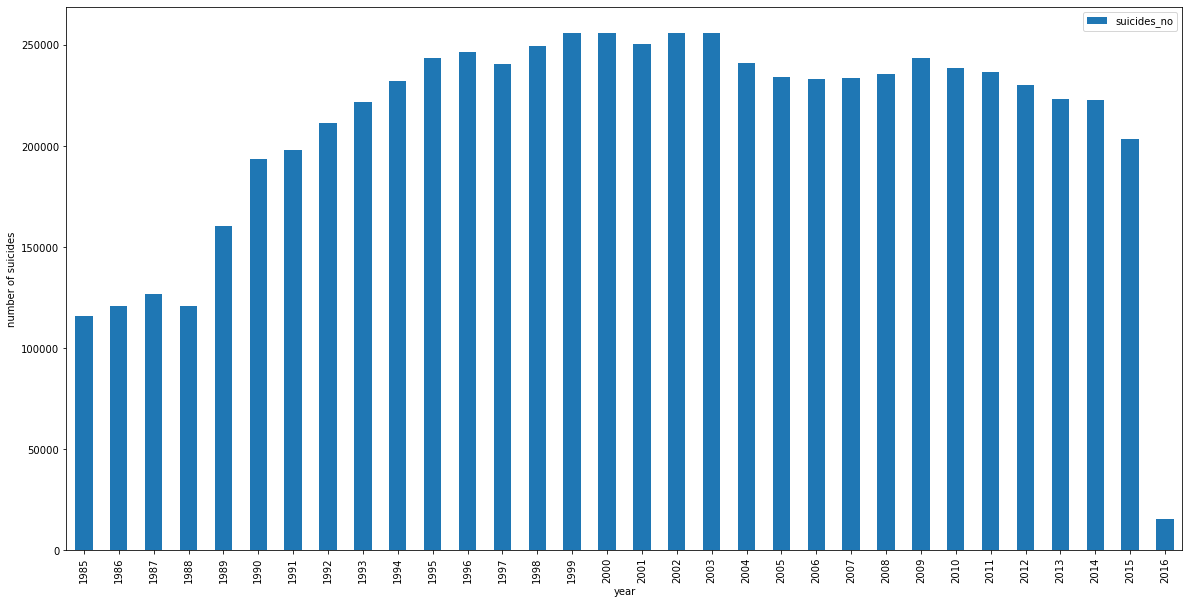

In [11]:
# cumulative suicides by year
# TODO also show averages? good way to show both on the same graph? with dual axis?
fig, ax = plt.subplots()

df_data_by_year = pd.DataFrame(data_by_year['suicides_no'].sum()) 
df_data_by_year['year'] = df_data_by_year.index
# deaths_by_year.plot.scatter(x='year', y='suicides_no', ax=ax, s=140, figsize=(20,10))
df_data_by_year.plot.bar(x='year', y='suicides_no', ax=ax, figsize=(20,10))
ax.set_xlabel('year')
ax.set_ylabel('number of suicides')

<AxesSubplot:ylabel='country'>

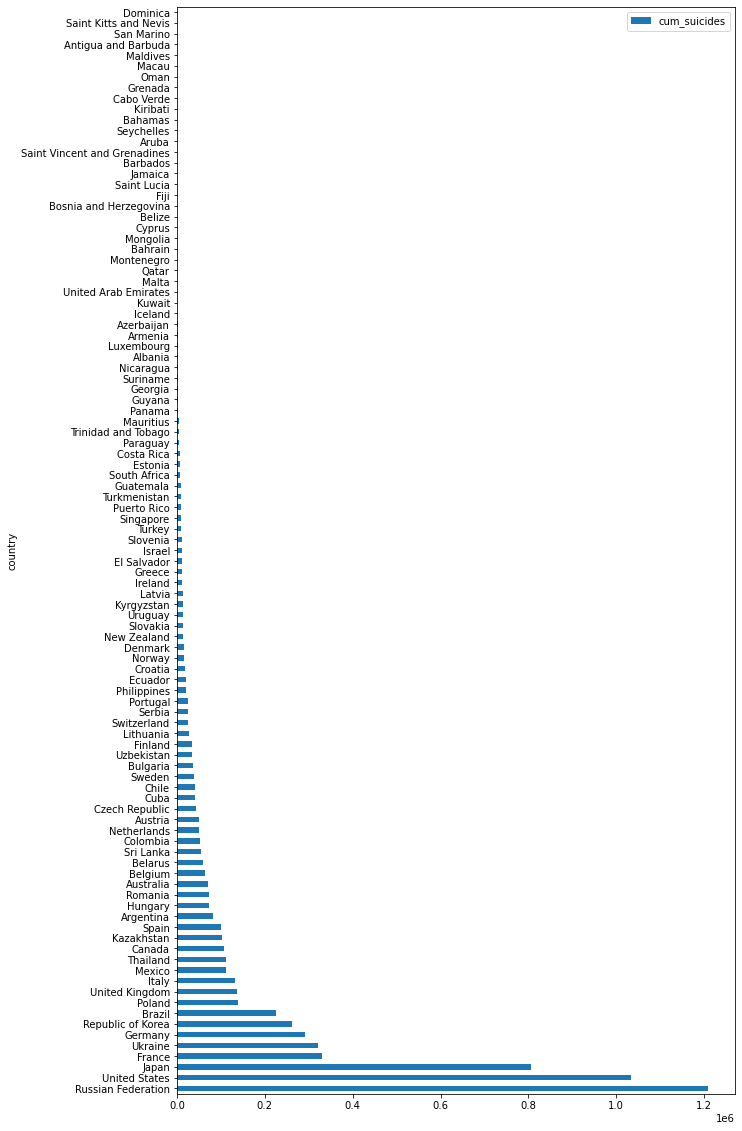

In [12]:
# cumulative suicides by country as a bar chart
fig, ax = plt.subplots()

df_by_country = pd.DataFrame()
df_by_country['cum_suicides'] = data_by_country['suicides_no'].sum()
# min/max normalization
df_by_country['norm_cum_suicides'] = (df_by_country['cum_suicides'] - df_by_country['cum_suicides'].min()) / (df_by_country['cum_suicides'].max() - df_by_country['cum_suicides'].min())

# TODO secondary x-axis to show actual as well as normalized: 
# https://matplotlib.org/3.1.0/gallery/subplots_axes_and_figures/secondary_axis.html 

df_by_country = df_by_country.sort_values('cum_suicides', ascending=False)
# df_by_country.plot.barh(y='norm_cum_suicides', ax=ax, figsize=(10,20))
df_by_country.plot.barh(y='cum_suicides', ax=ax, figsize=(10,20))

<AxesSubplot:xlabel='generation'>

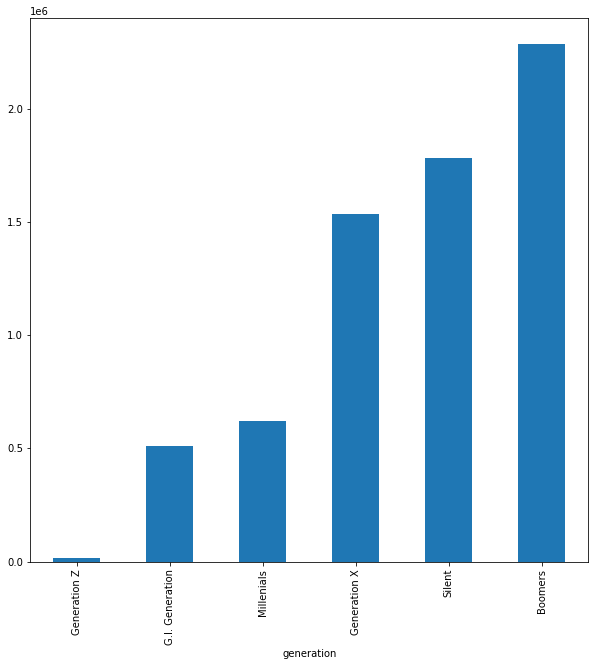

In [13]:
# cumulative suicides by generation
# TODO explain the skewed data due to the availability of data
# TODO wish we had more data e.g. how many boomers there are
fig, ax = plt.subplots()

df_by_gen = data_by_gen['suicides_no'].sum()
df_by_gen = df_by_gen.sort_values()
df_by_gen.plot.bar('suicides_no', ax=ax, figsize=(10,10))

<AxesSubplot:xlabel='age'>

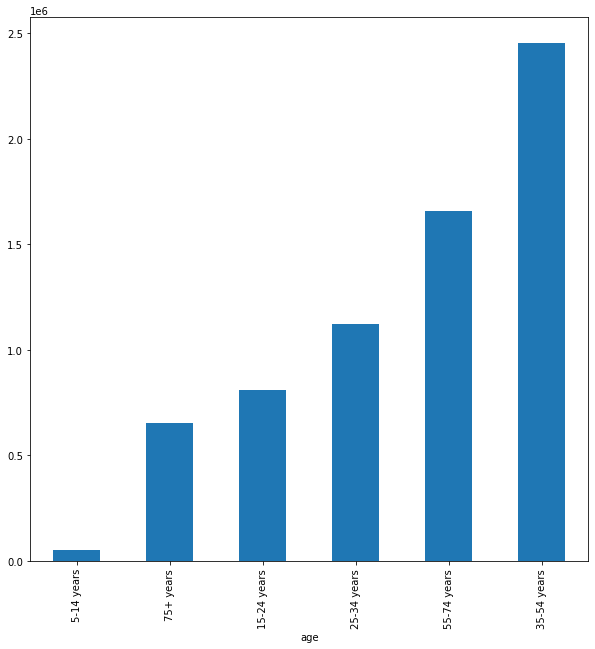

In [14]:
# cumulative suicides by age range
# TODO comment on the similarity to the previous graph
fig, ax = plt.subplots()

df_by_age = data_by_age['suicides_no'].sum()
df_by_age = df_by_age.sort_values()
df_by_age.plot.bar('suicides_no', ax=ax, figsize=(10,10))

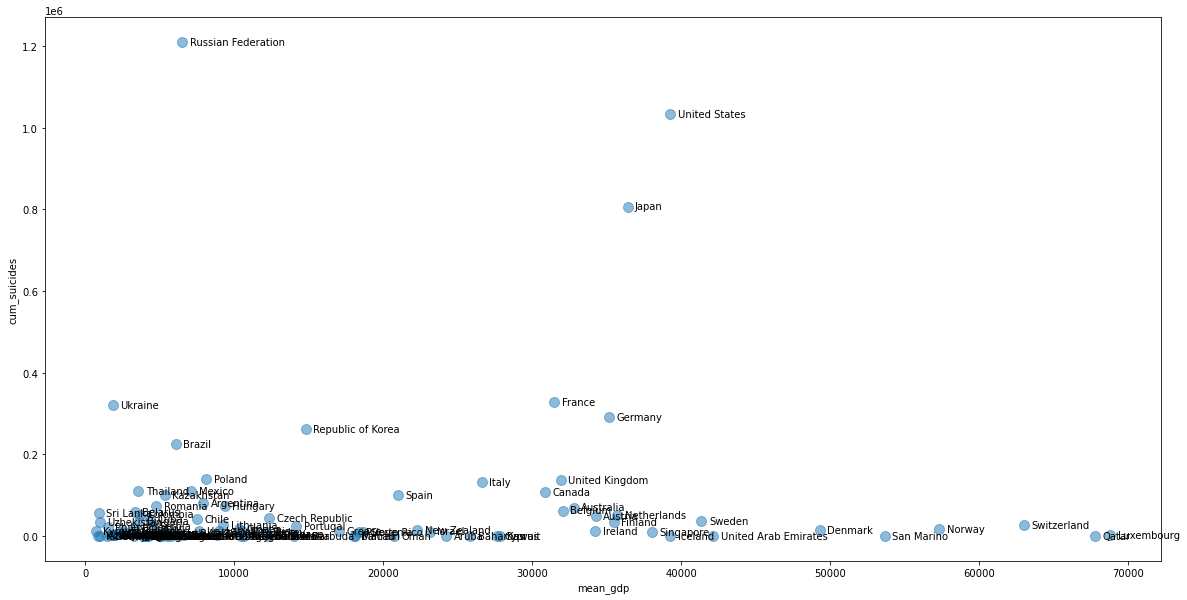

In [15]:
# cumulative suicides by age gdp per capita --> the lower the gdp, the higher the cum. suicides? I don't think this is correct...
fig, ax = plt.subplots()

df_by_gdp_pc = pd.DataFrame()
df_by_gdp_pc['mean_gdp'] = data_by_country['gdp_per_capita ($)'].mean()
df_by_gdp_pc['cum_suicides'] = data_by_country['suicides_no'].sum()
df_by_gdp_pc = df_by_gdp_pc.sort_values('mean_gdp')
#df_by_gdp_pc
# df_by_gdp_pc.plot.scatter(x='suicides_no', bins=600, ax=ax, figsize=(20,10))

# todo make this plot interactive: onhover show index name
    
df_by_gdp_pc.plot.scatter(x='mean_gdp', y='cum_suicides', ax=ax, s=100, alpha=0.5, figsize=(20,10))

for index, row in df_by_gdp_pc.iterrows():
    row = list(row)
    x, y = row[0], row[1]
    ax.text(x, y, index, ha='left', va='center', position=(x+500,y))



In [16]:
# TODO clustering based on GDP 
import sklearn.cluster as cl
km = cl.KMeans(n_clusters=10)
labels = km.fit_predict(df_by_gdp_pc)
df_by_gdp_pc['CID'] = labels
df_by_gdp_pc

,mean_gdp,cum_suicides,CID
country,,,
Kyrgyzstan,720.730769,13090,0
Kiribati,875.909091,53,0
Sri Lanka,904.272727,55641,5
Uzbekistan,976.181818,34803,5
Azerbaijan,1005.125000,1656,0
...,...,...,...
San Marino,53663.666667,4,8
Norway,57319.600000,16992,8
Switzerland,62981.761905,26217,8


# References
[1] The World Health Organization, [Suicide in the world: Global Health Estimates (booklet)](https://www.who.int/mental_health/prevention/suicide/suicideprevent/en/)

[2] American Foundation for Suicide Prevention, https://afsp.org/suicide-statistics/

### Credits:
| Task | Peter | Joseph | 
|------|-------|--------|
| Brainstorming broad topic/general ideation | x | x |
| idea to put together year in review + sentiment analysis | x | x | 
| Researching primary data set | x | x |
| Webscraping for secondary event data set | x |  |
| Drafting the report | x |  x |
| Revising, editing the report | |  x |